In [1]:
import pickle

with open('trainX.pkl', 'rb') as f:
    trainX = pickle.load(f)

with open('testX.pkl', 'rb') as f:
    testX = pickle.load(f)

with open('trainY.pkl', 'rb') as f:
    trainY = pickle.load(f)

with open('testY.pkl', 'rb') as f:
    testY = pickle.load(f)

with open('valX.pkl', 'rb') as f:
    valX = pickle.load(f)

with open('valY.pkl', 'rb') as f:
    valY = pickle.load(f)

with open('le.pkl', 'rb') as f:
    le = pickle.load(f)


In [2]:
from tensorflow.keras.applications import ResNet50

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D,Input
from tensorflow.keras.layers import Activation, Dropout,BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
s=150
batch_size = 40
epochs = 20

In [4]:
model_base = ResNet50(input_shape=(s, s,3), include_top=False)


In [5]:
x = Flatten()(model_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='sigmoid')(x)
model = keras.models.Model(model_base.input, x)


In [6]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['acc'])

In [7]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 3,
    verbose = 1,
    restore_best_weights = True
)

In [8]:
aug = ImageDataGenerator(rotation_range=0, zoom_range=0.0,width_shift_range=0.2, 
                         height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

In [9]:
resnet = model.fit(aug.flow(trainX, trainY, batch_size=batch_size), 
                     epochs=epochs,
                     callbacks = [early_stopping],
                     validation_data = (valX,valY),
                     verbose=1
)

Epoch 1/20
339/339 [==============================] - 110s 308ms/step - loss: 0.4766 - acc: 0.7324 - val_loss: 0.6206 - val_acc: 0.2811
Epoch 2/20
339/339 [==============================] - 102s 301ms/step - loss: 0.2415 - acc: 0.8244 - val_loss: 0.6346 - val_acc: 0.2276
Epoch 3/20
339/339 [==============================] - 102s 302ms/step - loss: 0.1807 - acc: 0.8724 - val_loss: 0.2969 - val_acc: 0.7484
Epoch 4/20
339/339 [==============================] - 102s 302ms/step - loss: 0.1698 - acc: 0.8795 - val_loss: 0.6429 - val_acc: 0.5604
Epoch 5/20
339/339 [==============================] - 102s 302ms/step - loss: 0.2204 - acc: 0.8350 - val_loss: 0.2892 - val_acc: 0.7927
Epoch 6/20
339/339 [==============================] - 102s 302ms/step - loss: 0.1827 - acc: 0.8655 - val_loss: 0.5645 - val_acc: 0.5571
Epoch 7/20
339/339 [==============================] - 102s 301ms/step - loss: 0.1563 - acc: 0.8870 - val_loss: 0.8912 - val_acc: 0.5075
Epoch 8/20
339/339 [============================

In [10]:
modelLoss, modelAccuracy = model.evaluate(aug.flow(testX, testY))

print('Test Loss is {}'.format(modelLoss))
print('Test Accuracy is {}'.format(modelAccuracy ))



133/133 [==============================] - 13s 94ms/step - loss: 0.3526 - acc: 0.7494
Test Loss is 0.3525990843772888
Test Accuracy is 0.749350368976593


In [11]:
# modelLoss, modelAccuracy = model.evaluate(aug.flow(trainX, trainY))

# print('Test Loss is {}'.format(modelLoss))
# print('Test Accuracy is {}'.format(modelAccuracy ))


In [12]:
# classification report on train
# predIdxs = model.predict(aug.flow(trainX), batch_size=batch_size)
# predIdxs = np.argmax(predIdxs, axis=1)
# print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

In [13]:
# classification report on test

predIdxs = model.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.17500   0.06777   0.09771       723
Lung Opacity    0.28843   0.27787   0.28305      1202
      Normal    0.49098   0.58705   0.53473      2039
   Pneumonia    0.06723   0.08922   0.07668       269

    accuracy                        0.37893      4233
   macro avg    0.25541   0.25548   0.24804      4233
weighted avg    0.35256   0.37893   0.35951      4233



In [14]:
class_names = ['Covid-19', 'Lung Opacity', 'Normal', 'Pneumonia']
y_pred = model.predict(aug.flow(testX))
print(class_names[np.argmax(y_pred[11])])

Normal


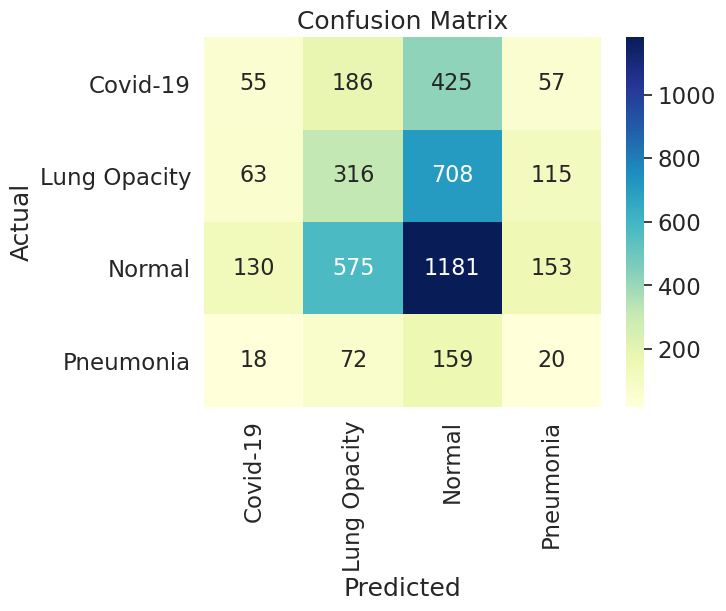

In [15]:
# Plotting Confusion Matrix
x = confusion_matrix(testY.argmax(axis=1),y_pred.argmax(axis=1))
Confusion_Matrix = pd.DataFrame(x,index=class_names, columns=class_names)

sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(Confusion_Matrix, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title('Confusion Matrix')
plt.show()

In [16]:
plt.plot(resnet.history['acc'], label='accuracy')
plt.plot(resnet.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='center right')


In [17]:
model.save('resnet50_model.h5') 

/home/scis/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
